In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

In [26]:
def preprocess(data, scaler):
    scaled_data = scaler().fit_transform(data.reshape(-1, 1)).reshape(data.shape)
    return scaled_data

file_name = "kdv_400_200_200_ver2"
out_name = file_name + "_nonlocal"
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

c1, c2, c3 = params.T
data = preprocess(raw_data, MaxAbsScaler)

Distance matrix: batch 1 of 16
Distance matrix: batch 2 of 16
Distance matrix: batch 3 of 16
Distance matrix: batch 4 of 16
Distance matrix: batch 5 of 16
Distance matrix: batch 6 of 16
Distance matrix: batch 7 of 16
Distance matrix: batch 8 of 16
Distance matrix: batch 9 of 16
Distance matrix: batch 10 of 16
Distance matrix: batch 11 of 16
Distance matrix: batch 12 of 16
Distance matrix: batch 13 of 16
Distance matrix: batch 14 of 16
Distance matrix: batch 15 of 16
Distance matrix: batch 16 of 16
Converged? True
[]


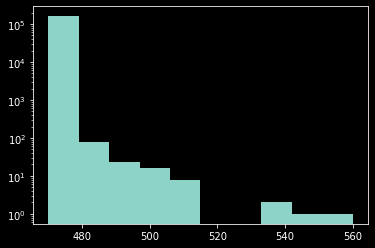

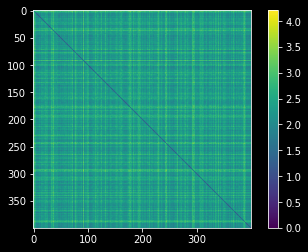

In [3]:
dist_mat, converged, steps = metrics.distance_matrix(data, batch_size=100, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)

plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [27]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
# dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']

In [5]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=100, alpha=1, robust=True)

nn_max = 3.418376615984514
epsilon = 23.370597377419475
mean_shift = 0.0032291521926937484


(-2.753638138553609,
 3.831215588271356,
 -1.8970998660673877,
 3.3840774160184544)

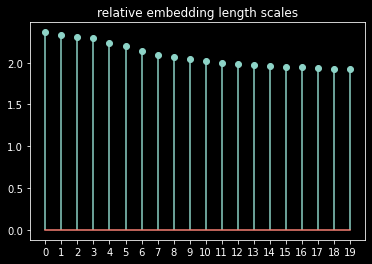

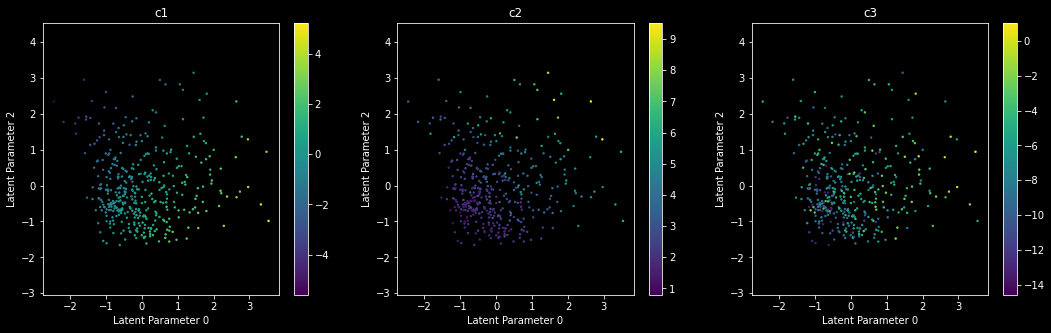

In [21]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(embedding[:,0], embedding[:,2], c=c1, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 2")
plt.title("c1")
plt.axis('equal')

plt.subplot(132)
plt.scatter(embedding[:,0], embedding[:,2], c=c2, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 2")
plt.title("c2")
plt.axis('equal')

plt.subplot(133)
plt.scatter(embedding[:,0], embedding[:,2], c=c3, s=2)
plt.colorbar()
plt.xlabel("Latent Parameter 0")
plt.ylabel("Latent Parameter 2")
plt.title("c3")
plt.axis('equal')

# plt.savefig("embedding.pdf", bbox_inches='tight')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


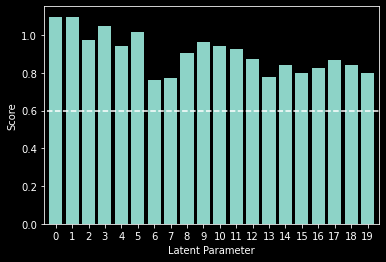

In [25]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

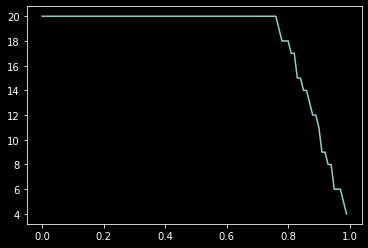

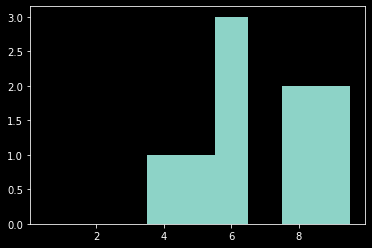

In [8]:
embedding_size_list = []
for thres in np.arange(0.0, 1., 0.01):
    embedding_size_list.append(len(manifold.heuristic_importance_score(evals, embedding, threshold=thres, weights="adjusted")[0]))

plt.figure()
plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10)+0.5);

R^2 = 0.8926953770761322
Coefficent(s): [ 0.82257585  0.22470416  0.96440587  0.29433467 -0.11252037  0.14728722
  0.00976856  0.00357961 -0.17943321  0.04001749  0.05242277  0.0760599
  0.0034093  -0.02660252 -0.19681727  0.07548758  0.06282337  0.00302775
  0.00267563 -0.01830866]


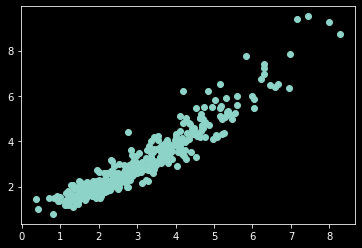

In [20]:
from sklearn.linear_model import LinearRegression
X = embedding[:, embed_list]
y = c2
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y);